# Thymio Control System

This notebook contains the main control loop for the Thymio robot, integrating vision, state estimation, and motion control modules implemented in separate files.

In [3]:
import tdmclient.notebook
await tdmclient.notebook.start()

In [ ]:
import numpy as np

from vision import VisionSystem
from state_estimation import ExtendedKalmanFilter
from control import ThymioController
from pathfinding import find_path
from utils import Pose, Point, euclidean_distance
from tdmclient import ClientAsync
import sys
import time


INITIAL_POSE = Pose(0, 0, 0)  # x, y, theta
INITIAL_COVARIANCE = np.eye(3) * 1e-1  # Initial uncertainty in state estimation
WAYPOINT_THRESHOLD = 3.0  # cm
BASICSPEED = 50
DT = 0.1  # Control loop time step in seconds

async def run():
    # A. Setup
    vis = VisionSystem()
    #ekf = ExtendedKalmanFilter(initial_pose=INITIAL_POSE, initial_covariance=INITIAL_COVARIANCE)
    controller = ThymioController()
    
    # B. Map & Plan
    graph, start_node, goal_node = vis.construct_map(cspace_padding=2.0)
    waypoints_idx = find_path(graph, start_node, goal_node)
    waypoints: list[Point] = [graph.nodes[i]['pos'] for i in waypoints_idx]
    current_waypoint_idx = 0

    print("Connectin to Thymio...")

    client = ClientAsync()
    node = await client.wait_for_node()
    #await node.lock()
    await node.stop()

    print("Thymio connected.")
    
    # Loop
    try:
        print("Starting main loop...")

        while True:
            start_time = time.time()

            await node.wait_for_variables(['prox.horizontal', 'motor.left.target', 'motor.right.target'])

            prox_sensors = list(node.v.prox.horizontal)
            print("Prox Sensors:", prox_sensors)

            # 1. Pose Measurement & Sensing
            vision_pose_measurement = vis.get_robot_pose() # May be None
            print("Vision Pose Measurement:", vision_pose_measurement)
            
            try:
                left_speed_measurement = node.v.motor.left.target
                right_speed_measurement = node.v.motor.right.target
            except Exception as e:
                print(f"Error reading motor speeds: {e}")
                left_speed_measurement = 0
                right_speed_measurement = 0

            # 2. State Estimation via EKF
            #ekf.predict(robot.left_speed, robot.right_speed, dt)
            #if vision_pose_measurement:
                #ekf.update(vision_pose_measurement)
            
            estimated_pose = vision_pose_measurement#ekf.get_state()
            
            
            # 3. PATH LOGIC
            if current_waypoint_idx < len(waypoints):
                target = waypoints[current_waypoint_idx]
                
                # Check if reached waypoint
                dist_to_wp = euclidean_distance(Point(*estimated_pose[:2]), target)
                if dist_to_wp < WAYPOINT_THRESHOLD:
                    print(f"Reached Waypoint {current_waypoint_idx}!")
                    current_waypoint_idx += 1
                    
                # Check if reached GOAL
                if current_waypoint_idx >= len(waypoints):
                    print("GOAL REACHED! Stopping.")
                    break # Exit loop
                
                # 4. CONTROL
                # Get commands from your controller
                # Ensure controller returns integers! Thymio expects ints.
                l_cmd, r_cmd = controller.update(estimated_pose, target, prox_sensors)
                

            # 5. SEND COMMANDS (Async)
            # We write to the variables. This doesn't send yet.
            #node.v.motor.left.target = int(l_cmd)
            #node.v.motor.right.target = int(r_cmd)
            v = {
                    "motor.left.target": [int(l_cmd)],
                    "motor.right.target": [int(r_cmd)],
                }
            print(f"Left cmd: {int(l_cmd)}, Right cmd: {int(r_cmd)}")
            await node.set_variables(v)
            
            # Force send the command packet immediately
            node.flush()
            
            # 6. LOOP TIMING
            # Calculate how much time the logic took, and sleep the remainder
            # to maintain a steady frequency (e.g., 10Hz)
            elapsed = time.time() - start_time
            if elapsed < DT:
                await client.sleep(DT - elapsed)

    finally:
        print("Stopping motors and unlocking Thymio...")
        v = {
                    "motor.left.target": [0],
                    "motor.right.target": [0],
                }
        await node.set_variables(v)
        node.flush()
        await node.unlock()

try:
    await run()
except KeyboardInterrupt:
    print("Program interrupted by user. Exiting...")
    


Warming up camera for 5 seconds...
Warmup complete. Camera is ready.
Point(x=np.float32(6.6044226), y=np.float32(67.023544))
Connectin to Thymio...
Thymio connected.
Starting main loop...
Prox Sensors: [0, 0, 0, 0, 0, 0, 0]
Capturing frame from camera...
Frame captured: True, shape: (1080, 1920, 3)
[-62.   8.]
Vision Pose Measurement: Pose(x=6.604422604422605, y=66.91128148959474, theta=np.float32(172.64758))
Reached Waypoint 0!
Left cmd: 16, Right cmd: 11
Prox Sensors: [0, 0, 0, 0, 0, 0, 0]
Capturing frame from camera...
Frame captured: True, shape: (1080, 1920, 3)
[-62.   8.]
Vision Pose Measurement: Pose(x=6.604422604422605, y=66.91128148959474, theta=np.float32(172.64758))
Left cmd: 5, Right cmd: -5
Prox Sensors: [0, 0, 0, 0, 0, 0, 0]
Capturing frame from camera...
Frame captured: True, shape: (1080, 1920, 3)
[-62.   8.]
Vision Pose Measurement: Pose(x=6.604422604422605, y=67.00109529025191, theta=np.float32(172.64758))
Left cmd: 5, Right cmd: -5
Prox Sensors: [0, 0, 0, 0, 0, 0, 0]

CancelledError: 

In [5]:
try:
    import asyncio
    asyncio.run(run())
except KeyboardInterrupt:
    print("Program interrupted by user. Exiting...")

RuntimeError: asyncio.run() cannot be called from a running event loop

In [1]:
from vision import VisionSystem

vis = VisionSystem(camera_index=1)

print(vis.get_robot_pose())


Warming up camera for 5 seconds...
Warmup complete. Camera is ready.
Capturing frame from camera...
Frame captured: True, shape: (1080, 1920, 3)
[ 47. -41.]
Pose(x=71.14754098360656, y=42.9780701754386, theta=np.float32(318.9005))


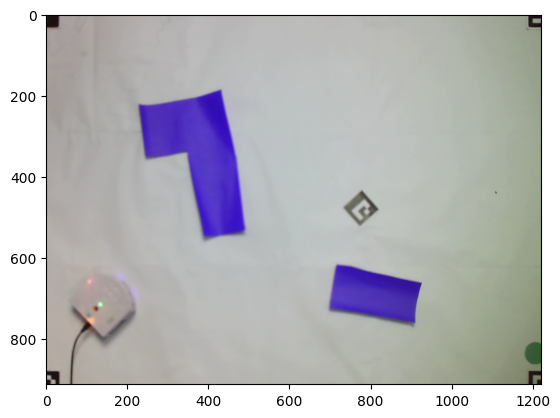

In [3]:
import matplotlib.pyplot as plt
plt.imshow(vis.warp_image(vis.img))

In [4]:
g, start, end = vis.construct_map()



Point(x=np.float32(71.19344), y=np.float32(42.955593))


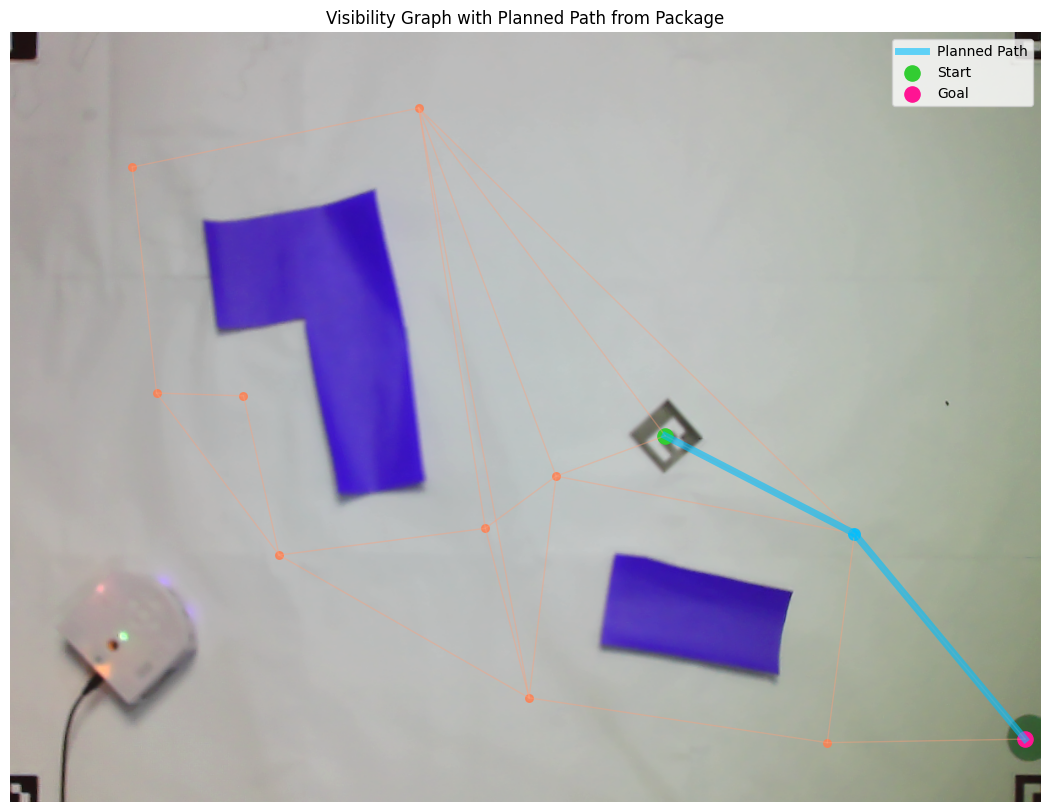

Capturing frame from camera...
Frame captured: True, shape: (1080, 1920, 3)
[ 46. -40.]
Pose(x=71.14754098360656, y=42.9780701754386, theta=np.float32(318.9909))
Capturing frame from camera...
Frame captured: True, shape: (1080, 1920, 3)
[ 46. -42.]
Pose(x=71.14754098360656, y=42.9780701754386, theta=np.float32(317.60257))


In [6]:
import matplotlib.pyplot as plt
from pathfinding import find_path


# Run the pathfinding
waypoints = find_path(g, start, end)
waypoints = [g.nodes[n]['pos'] for n in waypoints]  # Convert node IDs to world-space

# Visualize the resulting visibility graph
plt.figure(figsize=(16, 10))

# Add the warped image as background to enforce image coordinates (0,0 at top-left)
plt.imshow(vis.warp_image(vis.img))

# Plot all edges
for u, v in g.edges():
    p1 = g.nodes[u]['pos']
    p2 = g.nodes[v]['pos']
    xs = [p1[0] * vis.pxl_per_cm_x, p2[0] * vis.pxl_per_cm_x]
    ys = [p1[1] * vis.pxl_per_cm_y, p2[1] * vis.pxl_per_cm_y]
    plt.plot(xs, ys, color="lightsalmon", alpha=0.4, linewidth=1)

# Plot the waypoints path
for i in range(len(waypoints) - 1):
    p1 = waypoints[i]
    p2 = waypoints[i + 1]
    xs = [p1[0] * vis.pxl_per_cm_x, p2[0] * vis.pxl_per_cm_x]
    ys = [p1[1] * vis.pxl_per_cm_y, p2[1] * vis.pxl_per_cm_y]
    plt.plot(xs, ys, color="deepskyblue", alpha=0.6, linewidth=5, label="Planned Path" if i == 0 else "")

# Plot all nodes
for i in g.nodes():
    pt = g.nodes[i]['pos']
    color = "deepskyblue" if pt in waypoints else "coral"
    size = 70 if pt in waypoints else 30
    plt.scatter(pt[0] * vis.pxl_per_cm_x, pt[1] * vis.pxl_per_cm_y, color=color, s=size, alpha=0.8, marker="o")

# Highlight start and goal nodes
start_pos = g.nodes[start]['pos']
goal_pos = g.nodes[end]['pos']
plt.scatter(start_pos[0] * vis.pxl_per_cm_x, start_pos[1] * vis.pxl_per_cm_y, color="limegreen", s=120, marker="o", label="Start")
plt.scatter(goal_pos[0] * vis.pxl_per_cm_x, goal_pos[1] * vis.pxl_per_cm_y, color="deeppink", s=120, marker="o", label="Goal")

plt.title("Visibility Graph with Planned Path from Package")
plt.legend()
plt.axis("off")
plt.show()

print(vis.get_robot_pose())
print(vis.get_robot_pose())

In [15]:
for i in range(50):
    print(vis.get_robot_pose())

Capturing frame from camera...
Frame captured: True, shape: (1080, 1920, 3)
[ 46. -43.]
Pose(x=71.14754098360656, y=42.9780701754386, theta=np.float32(316.9306))
Capturing frame from camera...
Frame captured: True, shape: (1080, 1920, 3)
[33. 52.]
Pose(x=14.78032786885246, y=61.85964912280702, theta=np.float32(57.60016))
Capturing frame from camera...
Frame captured: True, shape: (1080, 1920, 3)
[35. 53.]
Pose(x=14.688524590163935, y=61.85964912280702, theta=np.float32(56.56012))
Capturing frame from camera...
Frame captured: True, shape: (1080, 1920, 3)
[33. 52.]
Pose(x=14.78032786885246, y=61.85964912280702, theta=np.float32(57.60016))
Capturing frame from camera...
Frame captured: True, shape: (1080, 1920, 3)
[33. 52.]
Pose(x=14.78032786885246, y=61.85964912280702, theta=np.float32(57.60016))
Capturing frame from camera...
Frame captured: True, shape: (1080, 1920, 3)
[36. 53.]
Pose(x=14.688524590163935, y=61.85964912280702, theta=np.float32(55.813873))
Capturing frame from camera...